### Necessary Libraries

In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from geopy.distance import geodesic
import os

### Data Loading

In [96]:
def load_data():

    try:
        # Construct the file path
        file_path = os.path.join('data', 'delivery.csv')
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Display basic information about the dataset
        print("\nDataset Info:")
        print("="*50)
        print(f"Number of records: {len(df)}")
        print(f"Number of features: {len(df.columns)}")
        print("\nColumns in dataset:")
        for col in df.columns:
            print(f"- {col}: {df[col].dtype}")
            # Show unique values for categorical columns
            if df[col].dtype == 'object':
                unique_values = df[col].unique()
                if len(unique_values) < 10:  # Only show if there aren't too many unique values
                    print(f"  Unique values: {unique_values}")
        
        return df
    
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None
    except Exception as e:
        print(f"Error loading the data: {str(e)}")
        return None

### Data Preprocessing

In [97]:
def load_and_preprocess_data(df):

    # Create a copy of the dataframe
    df = df.copy()
    
    # Check for missing values
    print("\nMissing values in each column:")
    print(df.isnull().sum())
    
    # Remove rows with missing values in critical columns
    critical_columns = ['Order_Date', 'Order_Time', 'Pickup_Time', 
                       'Store_Latitude', 'Store_Longitude', 
                       'Drop_Latitude', 'Drop_Longitude']
    
    initial_rows = len(df)
    df = df.dropna(subset=critical_columns)
    dropped_rows = initial_rows - len(df)
    print(f"\nDropped {dropped_rows} rows with missing values in critical columns")
    
    try:
        # Clean and format time columns
        # Remove any trailing/leading spaces
        df['Order_Time'] = df['Order_Time'].str.strip()
        df['Pickup_Time'] = df['Pickup_Time'].str.strip()
        
        # Ensure time format is correct (HH:MM:SS or HH:MM)
        def format_time(time_str):
            if pd.isna(time_str):
                return np.nan
            # If time is in seconds since midnight
            if str(time_str).isdigit():
                seconds = int(time_str)
                hours = seconds // 3600
                minutes = (seconds % 3600) // 60
                return f"{hours:02d}:{minutes:02d}:00"
            # If time is already in HH:MM or HH:MM:SS format
            return time_str if ':' in str(time_str) else np.nan
        
        df['Order_Time'] = df['Order_Time'].apply(format_time)
        df['Pickup_Time'] = df['Pickup_Time'].apply(format_time)
        
        # Convert to datetime
        df['Order_DateTime'] = pd.to_datetime(df['Order_Date'] + ' ' + df['Order_Time'])
        df['Pickup_DateTime'] = pd.to_datetime(df['Order_Date'] + ' ' + df['Pickup_Time'])
        
        # Calculate waiting time (time between order and pickup)
        df['Waiting_Time'] = (df['Pickup_DateTime'] - df['Order_DateTime']).dt.total_seconds() / 60
        
        # Calculate straight-line distance
        df['Distance'] = df.apply(lambda row: geodesic(
            (row['Store_Latitude'], row['Store_Longitude']),
            (row['Drop_Latitude'], row['Drop_Longitude'])
        ).kilometers, axis=1)
        
        # Extract hour from order time
        df['Hour'] = df['Order_DateTime'].dt.hour
        
        # Create time windows
        df['Time_Window'] = pd.cut(df['Hour'], 
                                 bins=[0, 6, 12, 18, 24],
                                 labels=['Night', 'Morning', 'Afternoon', 'Evening'])
        
        print("\nData preprocessing completed successfully")
        print(f"Final number of rows: {len(df)}")
        
        return df
    
    except Exception as e:
        print(f"Error during data preprocessing: {str(e)}")
        print("\nFirst few rows of problematic columns:")
        print("\nOrder_Time values:")
        print(df['Order_Time'].head(10))
        print("\nPickup_Time values:")
        print(df['Pickup_Time'].head(10))
        print("\nOrder_Date values:")
        print(df['Order_Date'].head(10))
        raise e

### BottleNecks Identification

In [98]:
def identify_bottlenecks(df):

    bottlenecks = {}
    
    # 1. Analyze delivery time by various factors
    bottlenecks['avg_delivery_by_weather'] = df.groupby('Weather')['Delivery_Time'].mean()
    bottlenecks['avg_delivery_by_traffic'] = df.groupby('Traffic')['Delivery_Time'].mean()
    bottlenecks['avg_delivery_by_vehicle'] = df.groupby('Vehicle')['Delivery_Time'].mean()
    bottlenecks['avg_delivery_by_area'] = df.groupby('Area')['Delivery_Time'].mean()
    bottlenecks['avg_delivery_by_time_window'] = df.groupby('Time_Window')['Delivery_Time'].mean()
    
    # 2. Analyze waiting times
    bottlenecks['avg_waiting_by_area'] = df.groupby('Area')['Waiting_Time'].mean()
    
    # 3. Calculate efficiency metrics
    df['Speed'] = df['Distance'] / (df['Delivery_Time'] / 60)  # km/hour
    bottlenecks['avg_speed_by_traffic'] = df.groupby('Traffic')['Speed'].mean()
    
    return bottlenecks

### Feature Importance

In [99]:
def feature_importance_analysis(df):
    
    # Prepare features for modeling
    features = ['Distance', 'Hour', 'Agent_Age', 'Agent_Rating']
    categorical_features = ['Weather', 'Traffic', 'Vehicle', 'Area']
    
    # Convert categorical variables to dummy variables
    df_model = pd.get_dummies(df, columns=categorical_features)
    
    # Select all features for model
    X = df_model.select_dtypes(include=['float64', 'int64'])
    X = X.drop(['Delivery_Time', 'Store_Latitude', 'Store_Longitude', 
                'Drop_Latitude', 'Drop_Longitude'], axis=1)
    y = df_model['Delivery_Time']
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return feature_importance

In [100]:
def print_feature_importance(feature_importance):

    print("\nFEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    print("\nFactors affecting delivery time (in order of importance):")
    print("-"*40)
    
    # Calculate total importance
    total_importance = feature_importance['importance'].sum()
    
    # Print each feature with its importance score and percentage
    for idx, (feature, importance) in enumerate(zip(feature_importance['feature'], 
                                                  feature_importance['importance']), 1):
        percentage = (importance / total_importance) * 100
        print(f"{idx}. {feature:30} : {importance:.4f} ({percentage:.2f}%)")

### Visualize Bottlenecks

In [101]:
def visualize_bottlenecks(df, bottlenecks):

    plt.figure(figsize=(15, 10))
    
    # 1. Delivery Time by Time Window
    plt.subplot(2, 2, 1)
    sns.boxplot(x='Time_Window', y='Delivery_Time', data=df)
    plt.title('Delivery Time Distribution by Time Window')
    plt.xticks(rotation=45)
    
    # 2. Delivery Time vs Traffic
    plt.subplot(2, 2, 2)
    sns.boxplot(x='Traffic', y='Delivery_Time', data=df)
    plt.title('Delivery Time Distribution by Traffic Condition')
    plt.xticks(rotation=45)
    
    # 3. Average Speed by Traffic
    plt.subplot(2, 2, 3)
    bottlenecks['avg_speed_by_traffic'].plot(kind='bar')
    plt.title('Average Speed by Traffic Condition')
    plt.xticks(rotation=45)
    
    # 4. Average Waiting Time by Area
    plt.subplot(2, 2, 4)
    bottlenecks['avg_waiting_by_area'].plot(kind='bar')
    plt.title('Average Waiting Time by Area')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

### Optimization & Recommendations

In [102]:
def generate_optimization_recommendations(bottlenecks, feature_importance):

    recommendations = []
    
    # Analyze traffic impact
    high_traffic_areas = bottlenecks['avg_delivery_by_traffic'].nlargest(2)
    recommendations.append(f"High impact of traffic in conditions: {', '.join(high_traffic_areas.index)}")
    
    # Analyze area efficiency
    problematic_areas = bottlenecks['avg_delivery_by_area'].nlargest(2)
    recommendations.append(f"Areas with longest delivery times: {', '.join(problematic_areas.index)}")
    
    # Time window analysis
    busy_windows = bottlenecks['avg_delivery_by_time_window'].nlargest(2)
    recommendations.append(f"Most challenging time windows: {', '.join(busy_windows.index)}")
    
    # Key factors from feature importance
    top_factors = feature_importance.head(3)
    recommendations.append("Top factors affecting delivery time:")
    for _, row in top_factors.iterrows():
        recommendations.append(f"- {row['feature']}: {row['importance']:.3f}")
    
    return recommendations

### Main Function

Loading data...

Dataset Info:
Number of records: 43739
Number of features: 16

Columns in dataset:
- Order_ID: object
- Agent_Age: int64
- Agent_Rating: float64
- Store_Latitude: float64
- Store_Longitude: float64
- Drop_Latitude: float64
- Drop_Longitude: float64
- Order_Date: object
- Order_Time: object
- Pickup_Time: object
- Weather: object
  Unique values: ['Sunny' 'Stormy' 'Sandstorms' 'Cloudy' 'Fog' 'Windy' nan]
- Traffic: object
  Unique values: ['High ' 'Jam ' 'Low ' 'Medium ' 'NaN ']
- Vehicle: object
  Unique values: ['motorcycle ' 'scooter ' 'van' 'bicycle ']
- Area: object
  Unique values: ['Urban ' 'Metropolitian ' 'Semi-Urban ' 'Other']
- Delivery_Time: int64
- Category: object

Preprocessing data...

Missing values in each column:
Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time          0
Pickup_Time         0
Weather            91


C:\Users\aryan\AppData\Local\Temp\ipykernel_19348\821797699.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bottlenecks['avg_delivery_by_time_window'] = df.groupby('Time_Window')['Delivery_Time'].mean()



FEATURE IMPORTANCE ANALYSIS

Factors affecting delivery time (in order of importance):
----------------------------------------
1. Speed                          : 0.5316 (53.16%)
2. Distance                       : 0.3757 (37.57%)
3. Hour                           : 0.0560 (5.60%)
4. Agent_Rating                   : 0.0307 (3.07%)
5. Agent_Age                      : 0.0058 (0.58%)
6. Waiting_Time                   : 0.0001 (0.01%)

Generating visualizations...


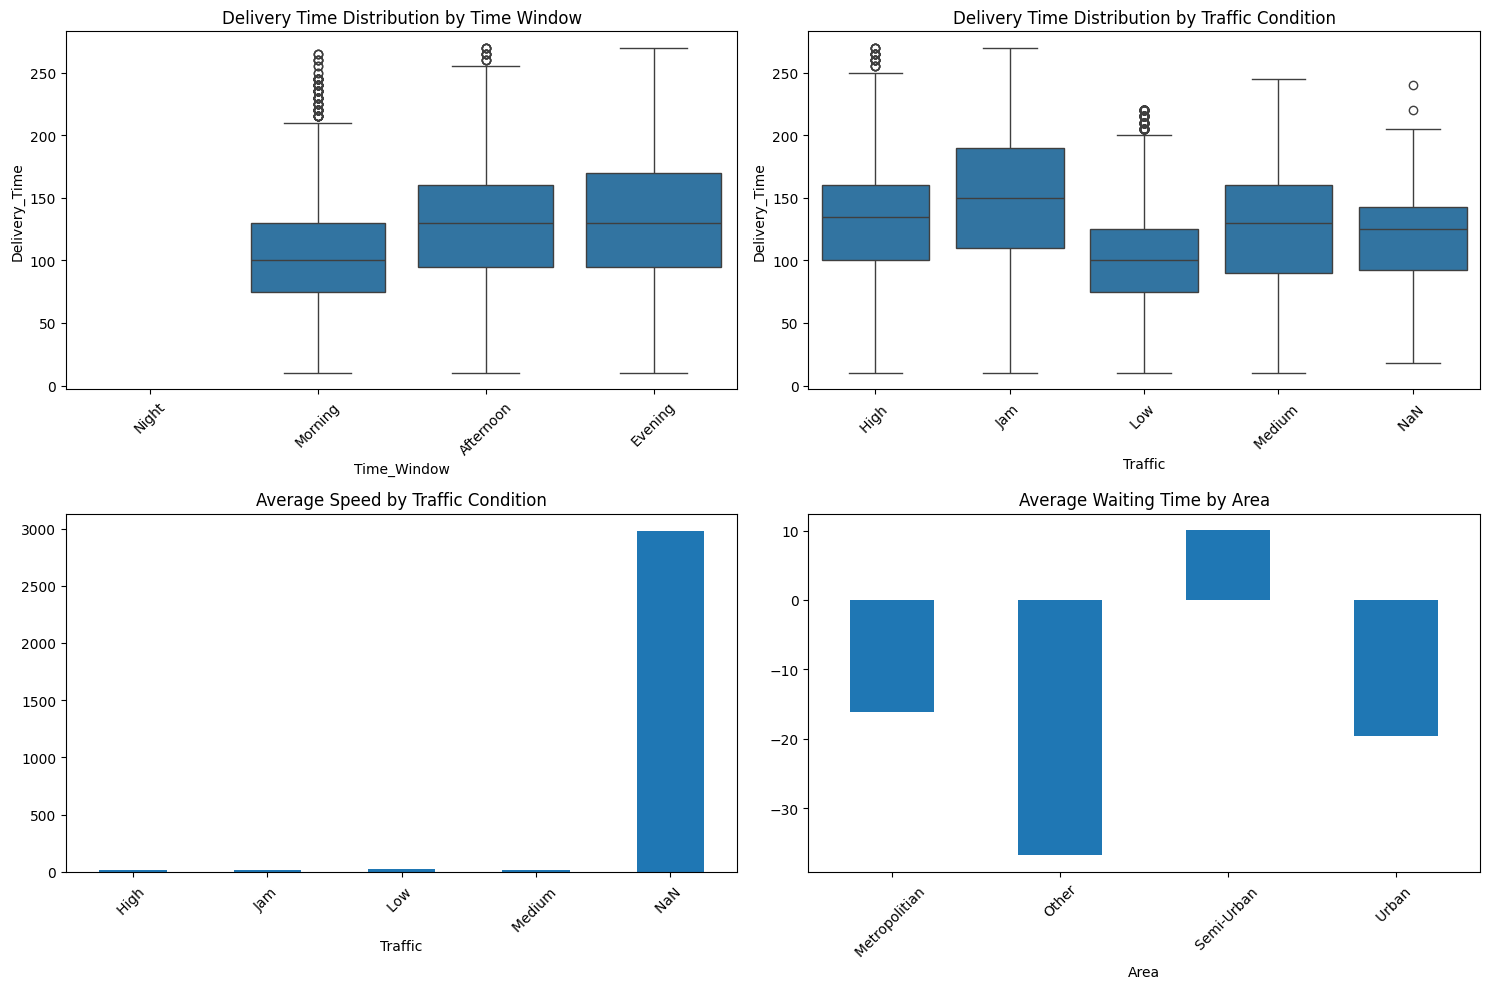


Generating recommendations...

Recommendations:
1. High impact of traffic in conditions: Jam , High 
2. Areas with longest delivery times: Semi-Urban , Metropolitian 
3. Most challenging time windows: Evening, Afternoon
4. Top factors affecting delivery time:
5. - Speed: 0.532
6. - Distance: 0.376
7. - Hour: 0.056


In [103]:
def main():

    # Load data
    print("Loading data...")
    df = load_data()
    
    if df is None:
        return
    
    # Preprocess data
    print("\nPreprocessing data...")
    df_processed = load_and_preprocess_data(df)
    
    # Identify bottlenecks
    print("\nIdentifying bottlenecks...")
    bottlenecks = identify_bottlenecks(df_processed)
    
    # Analyze feature importance
    print("\nAnalyzing feature importance...")
    feature_importance = feature_importance_analysis(df_processed)
    print_feature_importance(feature_importance)
    
    # Visualize results
    print("\nGenerating visualizations...")
    visualize_bottlenecks(df_processed, bottlenecks)
    
    # Generate recommendations
    print("\nGenerating recommendations...")
    recommendations = generate_optimization_recommendations(bottlenecks, feature_importance)
    
    # Print recommendations
    print("\nRecommendations:")
    print("="*50)
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    return {
        'bottlenecks': bottlenecks,
        'feature_importance': feature_importance,
        'recommendations': recommendations
    }

if __name__ == "__main__":
    main()